Classic Approach on Fuzzy Rules Prediction for Energy Prices
-----------------------------
Thomas Steinmann & Nidhi Makwana

This is the first of two implementations of a fuzzy rule based agent predicting energy prices. We use statistical analysis to create membership functions for all inputs & outputs as well as for rule selection.

First let us define imports as well as a helper method used for printing.

In [33]:
# -*- coding: utf-8 -*-
%matplotlib inline
"""
Created on Mon Apr  9 12:09:26 2018

@author: 19591676
"""

import sys
import numpy as np
from skfuzzy import control as ctrl, trimf, interp_membership
import matplotlib.pyplot as plt

# Print helper method
def print_inplace(text, percentage, time_taken=None, comment=""):
        percentage = int(percentage)
        length_factor = 5
        progress_bar = int(round(percentage/length_factor)) * "*" + (round((100-percentage)/length_factor)) * "."
        progress_bar = progress_bar[:round(len(progress_bar)/2)] + "|" + str(int(percentage)) + "%|" + progress_bar[round(len(progress_bar)/2):]
        sys.stdout.write("\r%s |%s|" % (text, progress_bar) + (" Time: %s" % str(time_taken).split(".")[0] if time_taken else "") + comment)
        sys.stdout.flush()

        if percentage == 100:
            print()



Then we define helper methods used for data loading and preprocessing

In [34]:
import csv
import numpy as np
from copy import deepcopy

def load_data(path):
    """
    Returns a dictionary containing the following values: t_2, t_1, t, d_2, d_1, d, p
    """
    t_2, t_1, t = [], [], []
    d_2, d_1, d = [], [], []
    p = []
    
    with open(path, newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            t_2.append(float(row['T(t-2)']))
            t_1.append(float(row['T(t-1)']))
            t.append(float(row['T(t)']))
            d_2.append(float(row['D(t-2)']))
            d_1.append(float(row['D(t-1)']))
            d.append(float(row['D(t)']))
            p.append(float(row['P(t+1)']))
            
    return {'t_2': t_2, 't_1': t_1, 't': t, 'd_2': d_2, 'd_1': d_1, 'd': d, 'p': p}        

def load_training_data():
    """
    Returns a dictionary containing the following values: t_2, t_1, t, d_2, d_1, d, p
    """
    return load_data('./data/2018_CI_Assignment_Training_Data.csv')

def load_test_data():
    """
    Returns a dictionary containing the following values: t_2, t_1, t, d_2, d_1, d, p
    """
    return load_data('./data/2018_CI_Assignment_Testing_Data.csv')

def remove_outliers(x):
    x = deepcopy(x)
    Q1 = np.percentile(x, 25)
    Q3 = np.percentile(x, 75)
    range = [Q1-1.5*(Q3-Q1),Q3+1.5*(Q3-Q1)]
    positions = np.concatenate((np.where(x>range[1]),np.where(x<range[0])),axis=1)[0]
    outliers = np.take(x, positions)
    if len(outliers) > 0:
        print('Removed outliers: \n%s' % outliers)
    return np.delete(x, positions), positions

def remove_outliers_from_dataset(data):
    """ Removes the outliers from an entire dataset using other low level helper methods """
    data = deepcopy(data)
    
    positions = set()
    for key in data:
        d, pos = remove_outliers(data[key])
        positions.update(pos)
    
    for key in data:
        data[key] = np.delete(data[key], list(positions))
    
    return data


Using the just defined methods we load the training and test data and remove outliers from both data sets
The distribution of the data sets after preprocessing is visualized and plotted below

Removed outliers: 
[ 64.85  72.77  95.09 103.77  97.24  69.41 155.25  55.3   59.61 101.08
 101.74 196.34 276.91 460.29 156.48 153.28 323.31  80.21  52.4   54.6
  54.69  52.18  58.32  56.47  71.13 144.21 187.   274.49 274.7   62.48
  71.91 183.76 109.23  64.6   55.71  79.26 216.23  59.87  84.36  80.19
  54.32  55.05 273.72  62.06  98.49 188.27  62.18  59.81  72.24  52.56
  55.95  54.8   53.5   54.07  55.4 ]
Removed outliers: 
[ 59.53  63.49 102.73 162.74 213.1  134.67 192.36 128.53 127.75 131.21
 213.88  99.3   99.3   59.32  56.08  59.05  58.03  58.13  60.12  56.34
 138.32]


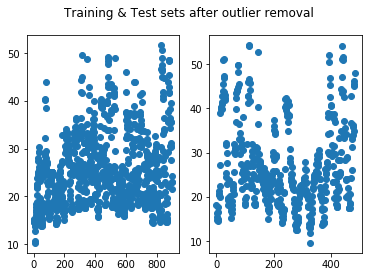

In [35]:
""" Data loading and preprocessing """
training_data = load_training_data()
training_data = remove_outliers_from_dataset(training_data)

plt.subplot(121)
plt.plot(training_data['p'], 'o')
plt.suptitle('Training & Test sets after outlier removal')

test_data = load_test_data()
test_data = remove_outliers_from_dataset(test_data)

plt.subplot(122)
plt.plot(test_data['p'], 'o')
plt.show()

Next we compute and plot a correlation matrix in order to determine which input values correlate to eachother.
This analysis shows two groups of inputs that are highly correlated within their respective groups but not to the other group.
We choose the two inputs that are most correlated to the output in each group and therefore not highly correlated to each other.

Correlation Coefficients Matrix Values: 
[[1.         0.97711422 0.94083427 0.43523077 0.49341031 0.54010843
  0.49325377]
 [0.97711422 1.         0.97678556 0.37103657 0.43915887 0.49715253
  0.46219849]
 [0.94083427 0.97678556 1.         0.29729518 0.37354107 0.44142236
  0.41799108]
 [0.43523077 0.37103657 0.29729518 1.         0.98603698 0.9497314
  0.52955784]
 [0.49341031 0.43915887 0.37354107 0.98603698 1.         0.98603361
  0.56492116]
 [0.54010843 0.49715253 0.44142236 0.9497314  0.98603361 1.
  0.5877078 ]
 [0.49325377 0.46219849 0.41799108 0.52955784 0.56492116 0.5877078
  1.        ]]


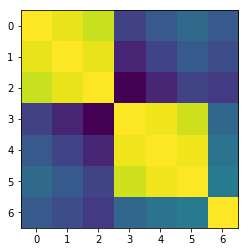

In [36]:
""" Correlation matrix """
# TODO: This could be automated
trainingA = np.row_stack((training_data['t_2'], training_data['t_1'], training_data['t'],
                          training_data['d_2'], training_data['d_1'], training_data['d'],
                          training_data['p']))

correlationCoefficients = np.corrcoef(trainingA)
fig = plt.figure()
ax = fig.add_subplot(111)
print('Correlation Coefficients Matrix Values: \n%s' % correlationCoefficients)
ax.imshow(correlationCoefficients, interpolation='nearest')
plt.show()

# Choose t-2, d and p for data set
trainingA = np.row_stack((training_data['t_2'], training_data['d'], training_data['p']))


In order to determine the form of the membership functions we draw histograms for each input of the test set and mimick the membership functions to have a similar form.

C:\Program Files\Anaconda\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


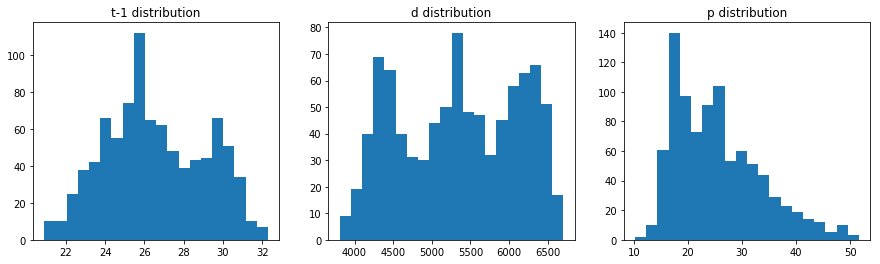

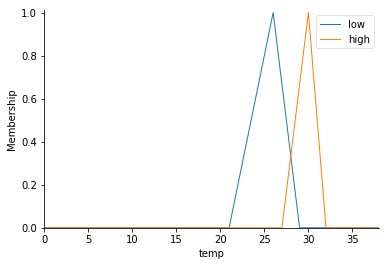

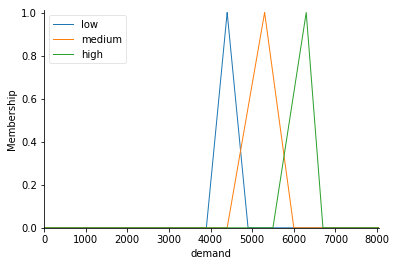

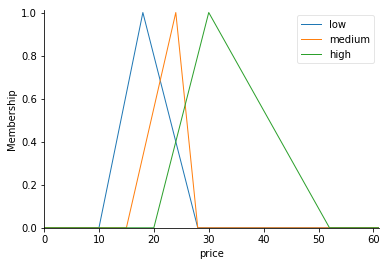

In [37]:
""" Fuzzy membership function definitions """
fig = plt.figure()
fig.set_figwidth(15)
ax = fig.add_subplot(131)
ax.hist(training_data['t_1'], 20)
ax.set_title('t-1 distribution')

ax = fig.add_subplot(132)
ax.hist(training_data['d'], 20)
ax.set_title('d distribution')

ax = fig.add_subplot(133)
ax.hist(training_data['p'], 20)
ax.set_title('p distribution')

temp = ctrl.Antecedent(np.arange(0, max(training_data['t_2'])*1.2, 1), 'temp')
temp_low = trimf(temp.universe, [21, 26, 29])
temp['low'] = temp_low
temp_high = trimf(temp.universe, [27, 30, 32])
temp['high'] = temp_high
temp.view()

demand = ctrl.Antecedent(np.arange(0, max(training_data['d'])*1.2, 1), 'demand')
demand_low = trimf(demand.universe, [3900, 4400, 4900])
demand['low'] = demand_low
demand_mid = trimf(demand.universe, [4400, 5300, 6000])
demand['medium'] = demand_mid
demand_high = trimf(demand.universe, [5500, 6300, 6700])
demand['high'] = demand_high
demand.view()

price = ctrl.Consequent(np.arange(0, max(training_data['p'])*1.2, 1), 'price')
price_low = trimf(price.universe, [10, 18, 28])
price['low'] = price_low
price_medium = trimf(price.universe, [15, 24, 28])
price['medium'] = price_medium
price_high = trimf(price.universe, [20, 30, 52])
price['high'] = price_high
price.view()

Finally we statistically analyse the support each possible rule gets from the training set. For this we draw a three dimensional array, one for each input/ output. We then compute the maximal degree of membership for each input value of the training set and sum up the max_membership values.

When plotting this array we can read out and select the rules with the most support from the test data set.

[[[192, 62, 45], [14, 7, 8]], [[22, 77, 64], [5, 18, 25]], [[8, 102, 44], [2, 63, 143]]]


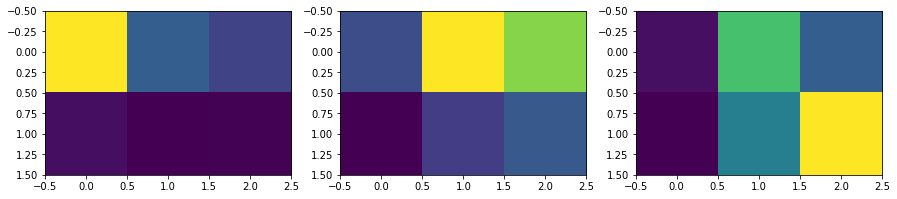

In [38]:
""" Statistical Analysis """
grid = [[[0, 0, 0], [0, 0, 0]], [[0, 0, 0], [0, 0, 0]], [[0, 0, 0], [0, 0, 0]]]

for t, d, p in zip(training_data['t_2'], training_data['d'], training_data['p']):
    t = max((interp_membership(temp.universe, temp_low, t), 0), (interp_membership(temp.universe, temp_high, t), 1))[1]
    d = max((interp_membership(demand.universe, demand_low, d), 0), (interp_membership(demand.universe, demand_mid, d), 1), (interp_membership(demand.universe, demand_high, d), 2))[1]
    p = max((interp_membership(price.universe, price_low, p), 0), (interp_membership(price.universe, price_medium, p), 1), (interp_membership(price.universe, price_high, p), 2))[1]
    grid[p][t][d] += 1

print(grid)
fig = plt.figure()
fig.set_figwidth(15)
ax = fig.add_subplot(131)
ax.imshow(grid[0], interpolation='nearest')
ax = fig.add_subplot(132)
ax.imshow(grid[1], interpolation='nearest')
ax = fig.add_subplot(133)
ax.imshow(grid[2], interpolation='nearest')
plt.show()

""" Fuzzy rules definitions """
# High support rules
rules = []
rules.append(ctrl.Rule(temp['low'] | demand['low'], price['low']))
rules.append(ctrl.Rule(temp['low'] | demand['medium'], price['medium']))
rules.append(ctrl.Rule(temp['high'] | demand['high'], price['high']))

# Medium support rules
#rules.append(ctrl.Rule(temp['low'] | demand['high'], price['medium']))
#rules.append(ctrl.Rule(temp['low'] | demand['medium'], price['high']))

Finally we build our simulation using the chosen rules and evaluate it against both the training and the test set

In [39]:
""" Build and evaluate simulation """
def evaluate_simulation(data_set):
    error = 0
    for t, d, p in zip(data_set['t_2'], data_set['d'], data_set['p']):
        simulation.input["temp"] = t
        simulation.input["demand"] = d
        simulation.compute()
        error += abs(simulation.output['price'] + p)/p

    return error / len(data_set['p'])


control_system = ctrl.ControlSystem(rules)
simulation = ctrl.ControlSystemSimulation(control_system)

print('Average training error: %s' % evaluate_simulation(training_data))
print('Average test error: %s' % evaluate_simulation(test_data))

Average training error: 2.0611827131658953
Average test error: 2.1155442125039934


Compare this to automatically computed membership functions

[[[0, 0, 0], [0, 0, 0], [0, 0, 0]], [[0, 0, 0], [0, 0, 0], [0, 0, 0]], [[0, 0, 0], [0, 0, 0], [0, 0, 901]]]


C:\Program Files\Anaconda\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


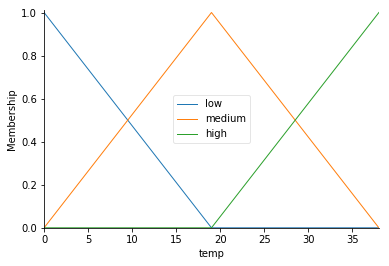

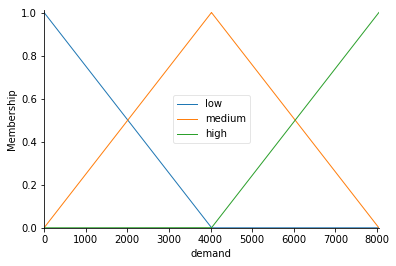

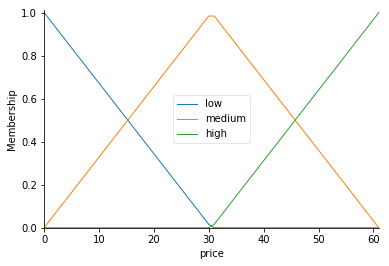

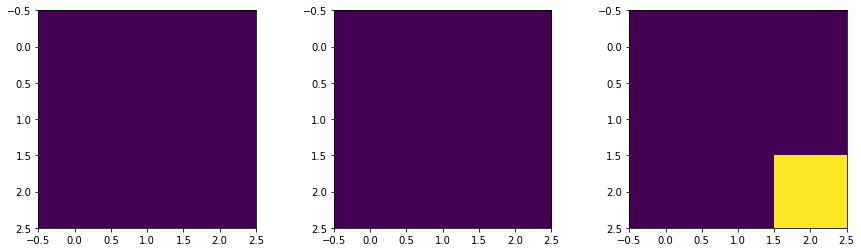

In [30]:
for uni in (temp, demand, price):
    uni.automf(3, names=['low', 'medium', 'high'])
    uni.view()
    
grid = [[[0, 0, 0], [0, 0, 0], [0, 0, 0]], [[0, 0, 0], [0, 0, 0], [0, 0, 0]], [[0, 0, 0], [0, 0, 0], [0, 0, 0]]]
for t, d, p in zip(training_data['t_2'], training_data['d'], training_data['p']):
    t = min((t-0, 0), (t-19, 1), (t-38, 2))[1]
    d = min((d-0, 0), (d-4000, 1), (d-8000, 2))[1]
    p = min((p-0, 0), (p-30, 1), (p-61, 2))[1]
    grid[p][t][d] += 1
    
print(grid)
fig = plt.figure()
fig.set_figwidth(15)
ax = fig.add_subplot(131)
ax.imshow(grid[0], interpolation='nearest')
ax = fig.add_subplot(132)
ax.imshow(grid[1], interpolation='nearest')
ax = fig.add_subplot(133)
ax.imshow(grid[2], interpolation='nearest')
plt.show()

This makes for a rather boring prediction with only one rule and a very bad prediction accuracy:

In [32]:
rules = [ctrl.Rule(temp['high'] | demand['high'], price['high'])]

control_system = ctrl.ControlSystem(rules)
simulation = ctrl.ControlSystemSimulation(control_system)

print('Average training error: %s' % evaluate_simulation(training_data))
print('Average test error: %s' % evaluate_simulation(test_data))

Average training error: 3.089022225497576
Average test error: 3.0530782935286838


Discussion
----------
This implementation showcases the importance of proper membership function design for prediction accuracy. Even with simple analysis of the training data and according adjustment of membership functions the prediction accuracy can be signifficantly improved.
